# Transfer Learning with Xception

In [1]:
from tensorflow.data import Dataset
from keras.utils import image_dataset_from_directory
from keras import layers, Model, Input
from keras.callbacks import EarlyStopping, TensorBoard  
import os
from shutil import rmtree
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from keras.applications import xception
import numpy as np
import pandas as pd

SOURCE = '/home/mniederer/workspace/data/new_data'
LOG_DIR = '/home/mniederer/workspace/Geo-KI/logs/CNN_material_new_data'
SOURCE_DATAFRAME = '/home/mniederer/workspace/data/new_material/umrisse_with_all_data.csv'
BATCH_SIZE = 25
EPOCHS = 40

2023-11-30 09:43:45.003272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## tf.data.Dataset for loading data
Dataset enables us to get more options and control for Preprocessing and Augmentation Process. The version with ImageDataGenerator is deprecated

In [4]:

dataset_train = image_dataset_from_directory(os.path.join(SOURCE,'train'), 
                                             image_size=(150,150),
                                             shuffle=True,
                                             )
dataset_train

Found 5768 files belonging to 11 classes.


2023-09-29 12:40:12.866100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 12:40:12.866979: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Load data

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, Model, Input
from keras.callbacks import EarlyStopping, TensorBoard  
import os
from shutil import rmtree
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from keras.applications import xception
import numpy as np

SOURCE = '/home/mniederer/workspace/data/new_data'
LOG_DIR = '/home/mniederer/workspace/Geo-KI/logs/CNN_material_new_data'
BATCH_SIZE = 25
EPOCHS = 40

# remove logs from previous executions
if os.path.isdir(os.path.join(LOG_DIR, 'train')):
    rmtree(os.path.join(LOG_DIR, 'train'))
if os.path.isdir(os.path.join(LOG_DIR, 'validation')):
    rmtree(os.path.join(LOG_DIR, 'validation'))


train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   #brightness_range=[0.3,0.9],
                                   horizontal_flip=True,
                                   vertical_flip=True)
train_generator = train_datagen.flow_from_directory(os.path.join(SOURCE,'train'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(os.path.join(SOURCE,'validation'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

# create test generator, important: shuffle=False so I can indentify the sources with test_generator.filenames
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(os.path.join(SOURCE,'test'), 
                                                    target_size=(150, 150), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 5768 images belonging to 11 classes.
Found 1236 images belonging to 11 classes.
Found 1243 images belonging to 11 classes.


### Using KerasTuner to find number of units in Dense Layers

best results: 416, 144
Dropout: 0.5

In [6]:
import keras_tuner as kt
from keras.callbacks import EarlyStopping

def model_builder(hp):
    conv_base = xception.Xception(weights='imagenet', include_top=False,
                              input_shape = (150,150,3))
    conv_base.trainable = False
    
    units_1 = hp.Int('units_1', min_value=64, max_value=512, step=32)
    units_2 = hp.Int('units_2', min_value=32, max_value=256, step=16)
    hp_dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5 ])


    inputs = Input(shape=(150,150,3))
    x = conv_base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)  # or layers.Flatten()?
    x = layers.Dense(416, activation='relu')(x) # units_1
    x = layers.Dense(144, activation='relu')(x) # units_2
    #more or less layers with more or less units?
    x = layers.Dropout(hp_dropout_rate)(x)  # modify dropout rate?
    outputs = layers.Dense(11, activation='softmax')(x)

    pretrainedModel = Model(inputs, outputs)

    pretrainedModel.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return pretrainedModel


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_generator, validation_data=validation_generator, epochs=30, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 27m 38s]
val_accuracy: 0.6569579243659973

Best val_accuracy So Far: 0.6642394661903381
Total elapsed time: 05h 55m 31s
INFO:tensorflow:Oracle triggered exit


In [7]:
#print(best_hps.get('units_1'))
#print(best_hps.get('units_2'))
print(best_hps.get('dropout_rate'))

0.5


## Training with frozen base network

In [9]:
from keras.utils import plot_model

conv_base = xception.Xception(weights='imagenet', include_top=False,
                              input_shape = (150,150,3))
conv_base.trainable = False

inputs = Input(shape=(150,150,3), name='InputLayer')
x = conv_base(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='GlobalAveragePool')(x)  # or layers.Flatten()?
x = layers.Dropout(0.5, name='Dropout50')(x)  # modify dropout rate?
x = layers.Dense(416, activation='relu', name='Dense416')(x)
#x = layers.Dense(128, activation='relu')(x) #optional
x = layers.Dense(144, activation='relu', name='Dense144')(x) #more or less layers with more or less units?
outputs = layers.Dense(11, activation='softmax', name='OutputLayer')(x)

pretrainedModel = Model(inputs, outputs)


pretrainedModel.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
pretrainedModel.summary()

plot_model(pretrainedModel, to_file='Pictures/Transfer_Learning_CNN.png', show_shapes=True, expand_nested=False, dpi=250)

# fit the model
history = pretrainedModel.fit(train_generator, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS,
                      validation_data=validation_generator,
                      callbacks=[EarlyStopping('val_accuracy', patience=10, min_delta=0.001, restore_best_weights=True),
                                 TensorBoard(log_dir=LOG_DIR, histogram_freq=1)])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 GlobalAveragePool (GlobalAv  (None, 2048)             0         
 eragePooling2D)                                                 
                                                                 
 Dropout50 (Dropout)         (None, 2048)              0         
                                                                 
 Dense416 (Dense)            (None, 416)               852384    
                                                                 
 Dense144 (Dense)            (None, 144)               60048     
                                                           

### Training history

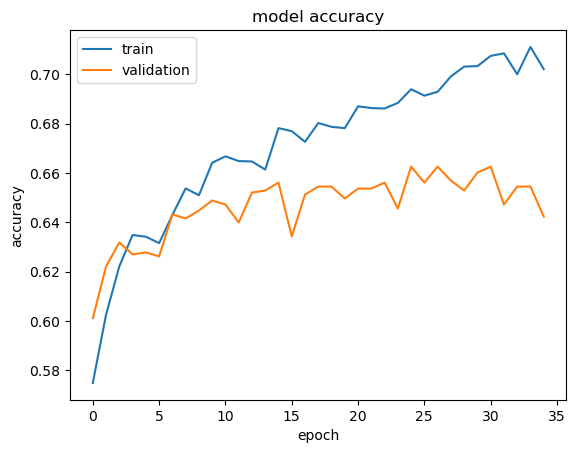

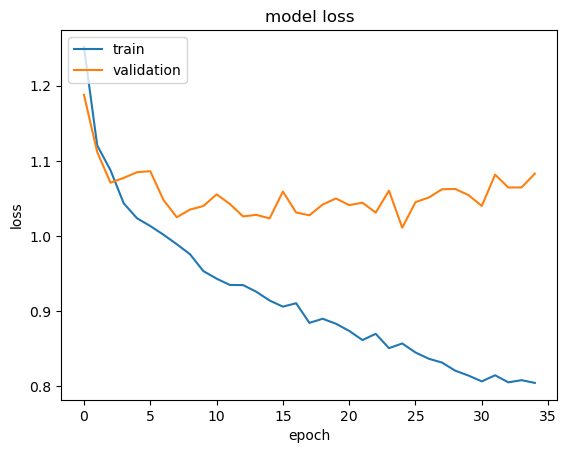

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluation

In [11]:
score=pretrainedModel.evaluate(test_generator)

print("Test score:", score[0])
print("Test accuracy:", score[1])


19/50 [==========>...................] - ETA: 8s - loss: 1.8058 - accuracy: 0.3937

50/50 [==============================] - 14s 268ms/step - loss: 1.0561 - accuracy: 0.6420
Test score: 1.0560650825500488
Test accuracy: 0.6419951915740967


In [12]:
#get y_test
num_batches=  int(len(test_generator.filenames) / BATCH_SIZE)
batches_of_y= []
batches_of_x= []

for i in range(num_batches+1):
    x,y = test_generator[i]
    batches_of_y.append(np.argmax(y, axis=1))
    batches_of_x.append(x)

y_test = np.concatenate(batches_of_y, axis=0)
x_test = np.concatenate(batches_of_x, axis=0)
#generate predictions
y_pred = np.argmax(pretrainedModel.predict(test_generator), axis=1)
print(classification_report(y_test, y_pred))


 2/50 [>.............................] - ETA: 15s

50/50 [==============================] - 14s 269ms/step
              precision    recall  f1-score   support

           0       0.54      0.44      0.48       135
           1       0.41      0.42      0.42       120
           2       0.50      0.24      0.33       112
           3       0.00      0.00      0.00         4
           4       0.33      0.30      0.32        20
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.50      0.44      0.47       195
           8       0.14      0.10      0.11        21
           9       0.54      0.32      0.40        22
          10       0.76      0.92      0.83       611

    accuracy                           0.64      1243
   macro avg       0.34      0.29      0.30      1243
weighted avg       0.61      0.64      0.62      1243



/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

## Fine-Tuning
Unfreeze base network and update weights based on train_data. We want to update the weights very cautiously, so the learning rate is set very low in this step

In [13]:
conv_base.trainable = True

# we dont want to train the first layers: These early layers encode more generic reusable features. These layers we want to keep as is.
for layer in conv_base.layers[:-6]:   # how many we wanna keep trainable? 4,5,6,7? 6 as this is entire block 14
    layer.trainable = False

#recompile model to take changes into account
pretrainedModel.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])  # i tried different learning rates: 1e-4, 1e-5, 1e-6
pretrainedModel.summary()

# fit the model
history = pretrainedModel.fit(train_generator, 
                      batch_size=BATCH_SIZE, 
                      epochs=20,
                      validation_data=validation_generator,
                      callbacks=[EarlyStopping('val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
                                 TensorBoard(log_dir=LOG_DIR, histogram_freq=1)])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 GlobalAveragePool (GlobalAv  (None, 2048)             0         
 eragePooling2D)                                                 
                                                                 
 Dropout50 (Dropout)         (None, 2048)              0         
                                                                 
 Dense416 (Dense)            (None, 416)               852384    
                                                                 
 Dense144 (Dense)            (None, 144)               60048     
                                                           

231/231 [==============================] - 352s 2s/step - loss: 0.7822 - accuracy: 0.7136 - val_loss: 0.9841 - val_accuracy: 0.6861
Epoch 2/20
231/231 [==============================] - 347s 2s/step - loss: 0.7176 - accuracy: 0.7424 - val_loss: 0.9875 - val_accuracy: 0.6828
Epoch 3/20
231/231 [==============================] - 421s 2s/step - loss: 0.6967 - accuracy: 0.7483 - val_loss: 0.9758 - val_accuracy: 0.6828
Epoch 4/20
231/231 [==============================] - 466s 2s/step - loss: 0.6861 - accuracy: 0.7462 - val_loss: 0.9554 - val_accuracy: 0.6934
Epoch 5/20
231/231 [==============================] - 457s 2s/step - loss: 0.6550 - accuracy: 0.7621 - val_loss: 0.9776 - val_accuracy: 0.6917
Epoch 6/20
231/231 [==============================] - 389s 2s/step - loss: 0.6505 - accuracy: 0.7571 - val_loss: 0.9788 - val_accuracy: 0.6934
Epoch 7/20
231/231 [==============================] - 480s 2s/step - loss: 0.6320 - accuracy: 0.7663 - val_loss: 0.9725 - val_accuracy: 0.7015
Epoch 8/20

### Evaluation

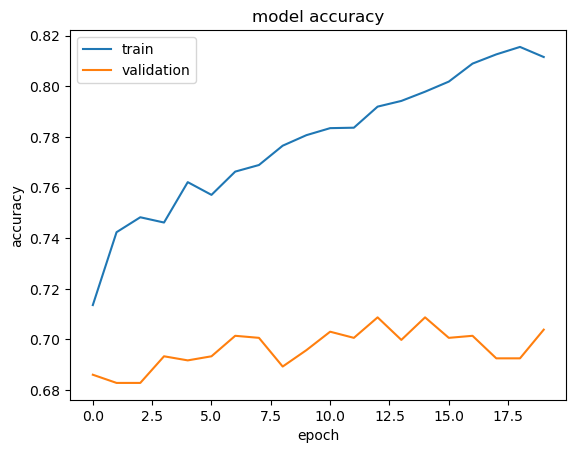

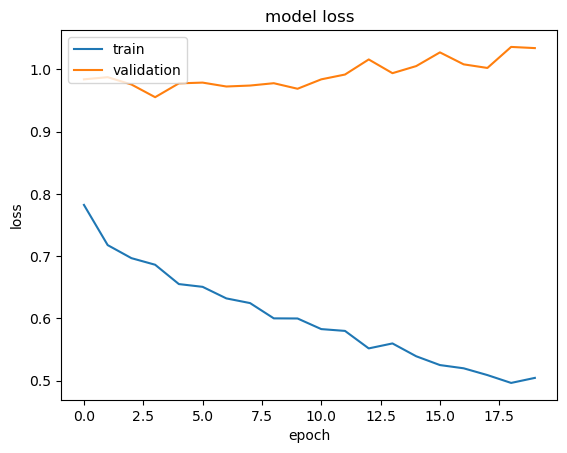

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
score=pretrainedModel.evaluate(test_generator)

print("Test score:", score[0])
print("Test accuracy:", score[1])


50/50 [==============================] - 19s 384ms/step - loss: 1.0492 - accuracy: 0.6782
Test score: 1.0491615533828735
Test accuracy: 0.6781979203224182


In [16]:
y_test = test_generator.classes
y_pred = np.argmax(pretrainedModel.predict(test_generator), axis=1)

print(classification_report(y_test, y_pred))


50/50 [==============================] - 19s 380ms/step
              precision    recall  f1-score   support

           0       0.56      0.44      0.49       135
           1       0.42      0.47      0.44       120
           2       0.52      0.34      0.41       112
           3       0.00      0.00      0.00         4
           4       0.33      0.25      0.29        20
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.53      0.53      0.53       195
           8       0.12      0.10      0.11        21
           9       0.67      0.73      0.70        22
          10       0.83      0.92      0.88       611

    accuracy                           0.68      1243
   macro avg       0.36      0.34      0.35      1243
weighted avg       0.66      0.68      0.67      1243



/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mniederer/anaconda3/envs/dl/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

## Save model

In [11]:
pretrainedModel.save('pretrained_model.h5')

In [17]:
df = pd.read_csv('/home/mniederer/workspace/data/new_material/umrisse_with_all_data_and_shape_and_patch.csv', index_col=0)


for i,filename in enumerate(test_generator.filenames):
    id = int(filename.split('_')[2].split('.')[0])
    df.loc[ df['id'] == id, 'Pred_normal'] = y_pred[i]


df.to_csv('/home/mniederer/workspace/data/new_material/umrisse_with_all_data_and_shape_and_patch_and_normal.csv')

In [18]:
#df.loc[ df.pred]
df.loc[df['Pred_Patch'] < 50].head(50)

,WKT,mat_qgis,ezg,id,area_type,area,Shape,Pred_Patch,Pred_normal
3,MULTIPOLYGON (((2554401.78578927 5467544.70283...,Bitumen,Industriegebiet_Fordwerke,4,0,1308.61,1000,2.0,2.0
11,MULTIPOLYGON (((2554220.12078498 5467750.63027...,Bitumen,Industriegebiet_Fordwerke,12,0,1574.53,1000,2.0,NaN
23,MULTIPOLYGON (((2554008.97439121 5467612.11955...,Bitumen,Industriegebiet_Fordwerke,24,0,328.48,1000,2.0,NaN
35,MULTIPOLYGON (((2554250.53728924 5467681.97516...,Asbest|Faserzement,Industriegebiet_Fordwerke,36,0,461.97,3100,2.0,NaN
96,MULTIPOLYGON (((2555964.41777604 5467941.59968...,Beton,Industriegebiet_Fordwerke,97,0,30.23,1000,1.0,2.0
97,MULTIPOLYGON (((2555577.56607609 5467746.11040...,Bitumen,Industriegebiet_Fordwerke,98,0,1758.38,1000,2.0,NaN
100,MULTIPOLYGON (((2555912.60644246 5467942.52606...,Bitumen,Industriegebiet_Fordwerke,101,0,152387.73,9999,2.0,2.0
101,MULTIPOLYGON (((2555783.15255007 5468378.35665...,Asbest|Faserzement,Industriegebiet_Fordwerke,102,0,4655.06,1000,0.0,NaN
105,MULTIPOLYGON (((2556358.20541658 5468115.75987...,Bitumen,Industriegebiet_Fordwerke,106,0,21921.41,1000,2.0,NaN
112,MULTIPOLYGON (((2555399.2611526 5468065.684414...,Beton,Industriegebiet_Fordwerke,113,0,20.05,1000,1.0,NaN


## Prepare data for Geo-Engineers

In [19]:
import pandas as pd
import re
SOURCE_DATAFRAME = '/home/mniederer/workspace/data/new_material/umrisse_with_all_data.csv'
SOURCE_DIR = '/home/mniederer/workspace/data/new_material'


df_raw = pd.read_csv(os.path.join(SOURCE_DIR, 'umrisse_und_material.csv'))

df = pd.read_csv(SOURCE_DATAFRAME, index_col=0)

In [20]:
filenames = test_generator.filenames
class_names = os.listdir(os.path.join(SOURCE,'test'))
class_names.sort()
class_names[10] = 'Ziegel Rot'
ids = []
for file in filenames:
    splitted = re.split('[_.]', file)
    id = int(splitted[2])
    ids.append(id)


df_raw['Prediction'] = ''

for index,id in enumerate(ids):
    df_raw.loc[ df_raw['id'] == id, 'Prediction'] = class_names[y_pred[index]]

df_filtered = df_raw.loc[ df_raw['Prediction'] != '']
df_filtered.to_csv('Mischgebiet_Landsweiler-Reden.csv')





